# Custom implementation of WST in PyTorch

Instead of using the `kymatio` package, we implement our version of the wavelet scattering transform (WST) in PyTorch. The goals are:
1. Learn more about PyTorch.
2. See how the WST works under the hood.
3. Have more flexibility on the filters used in the WST.



In [1]:
import datetime

import numpy as np

from skimage import io
from skimage.util import img_as_float32, img_as_ubyte

import torch
import torch.nn.functional as F
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Selecting {device} as computing device.')

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

Selecting cuda as computing device.


## Load examples

We can try examples from histology slides, turbulence, various textures. Images are stored in the `inputs` folder. They should be greyscale. The loose naming convention is:
- [no prefix]: 512x512 pixels
- `_small`: 256x256
- `_tiny`: 128x128
- `_nano`: 64x64

In [2]:
files = [
    'inputs/histology1_tiny.tiff',
    'inputs/histology3_tiny.tiff',
    'inputs/isotropic_turbulence_tiny.tiff',
    'inputs/shirt_tiny.tiff',
    'inputs/ifm_tiny.tiff',
]

In [3]:
images = []
for name in files:
    images.append(img_as_float32(io.imread(name)))

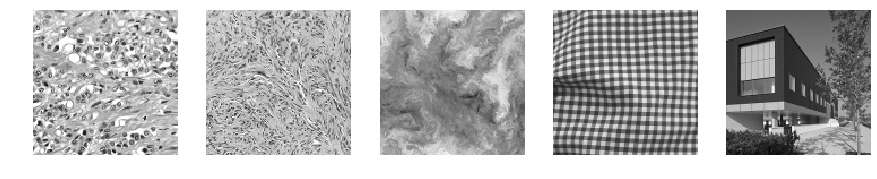

In [4]:
plt.rcParams["figure.figsize"] = (15,5)
figure, ax = plt.subplots(ncols=len(images))
for i, image in enumerate(images):
    ax[i].imshow(image, cmap='gray', vmin=0, vmax=1)
    ax[i].axis('off')
plt.show()

## Define wavelets

We define wavelets for all scales and orientation. Here we use bump steerable wavelets (see https://arxiv.org/abs/2006.06298). Note that the kymatio package uses Gabor wavelets.

`J` is the number of scales (here all scales), `L` is the number of angles.

In [5]:
image = images[0]

# Number of scales
J = int(np.log2(image.shape[0]))

# Number of angles
L = 4

image_hat = np.fft.fftshift(np.fft.fft2(image))

Li, Lj = image.shape
ki, kj = np.meshgrid(np.fft.fftshift(np.fft.fftfreq(Li)), np.fft.fftshift(torch.fft.fftfreq(Lj)))

k2 = ki**2+kj**2

theta = np.arctan(kj/ki)
theta[ki==0] = np.pi/2

# Anti-aliasing at J=0
aa = False
if aa:
    kiaa, kjaa = np.meshgrid(np.fft.fftshift(np.fft.fftfreq(2*Li)), np.fft.fftshift(torch.fft.fftfreq(2*Lj)))
    kiaa *= 2
    kjaa *= 2
    k2aa = kiaa**2+kjaa**2
    thetaaa = np.arctan(kjaa/kiaa)
    thetaaa[kiaa==0] = np.pi/2


ws = []

for j in range(J):
    for l in range(L):
        if aa and j==0:
            k1 = (np.sqrt(k2aa) - 0.5)/0.5
            w1 = np.exp(-k1**2/(1-k1**2))*np.abs(np.cos(thetaaa+l*np.pi/L))**(L-1)
            w1[k1**2>=1] = 0
            w1 = np.roll(w1, -Li//2, axis=(0, 1))
            w0 = w1[:Li, :Lj] +  w1[:Li, Lj:] +  w1[Li:, :Lj] +  w1[Li:, Lj:]
            w0 /= np.max(w0)
        else:
            k1 = (np.sqrt(k2) - (0.5/2**j))/(0.5/2**j)
            w0 = np.exp(-k1**2/(1-k1**2))*np.abs(np.cos(theta+l*np.pi/L))**(L-1)
            w0[k1**2>=1] = 0
        ws.append(w0)

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp


We can have a look at the filter in the Fourier domain:

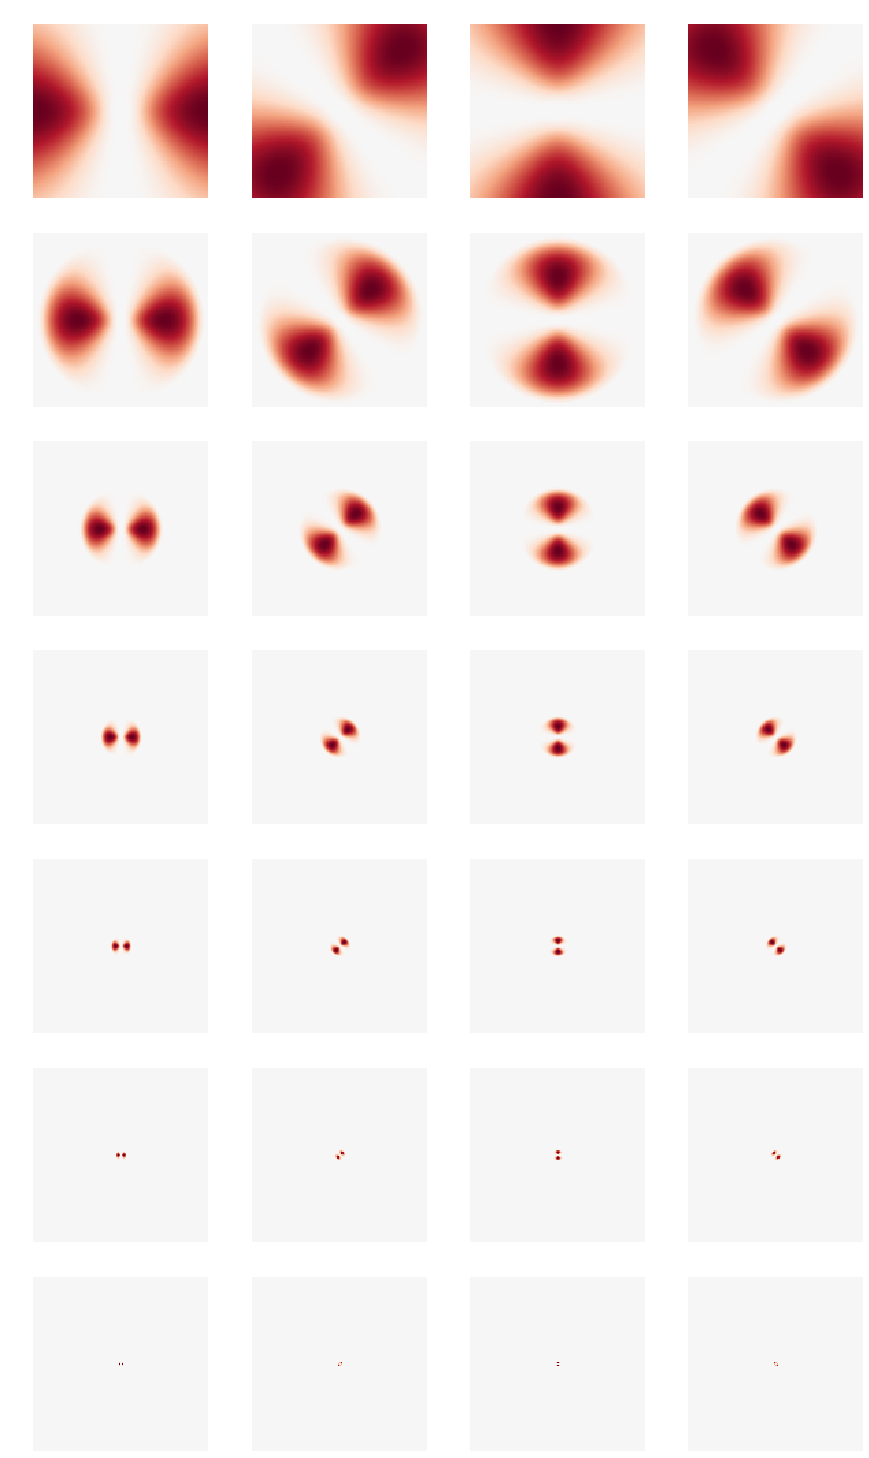

In [6]:
plt.rcParams["figure.figsize"] = (15,15*J/L)
figure, ax = plt.subplots(ncols=L, nrows=J)
for j in range(J):
    for l in range(L):
        ax[j, l].matshow(ws[j*L+l], cmap='RdBu_r', vmin=-1, vmax=1)
        ax[j, l].axis("off")
        
# After inspection we can unshift the spectra
ws = np.array(ws).astype('float')
for i in range(len(ws)):
    ws[i] = np.fft.ifftshift(ws[i])

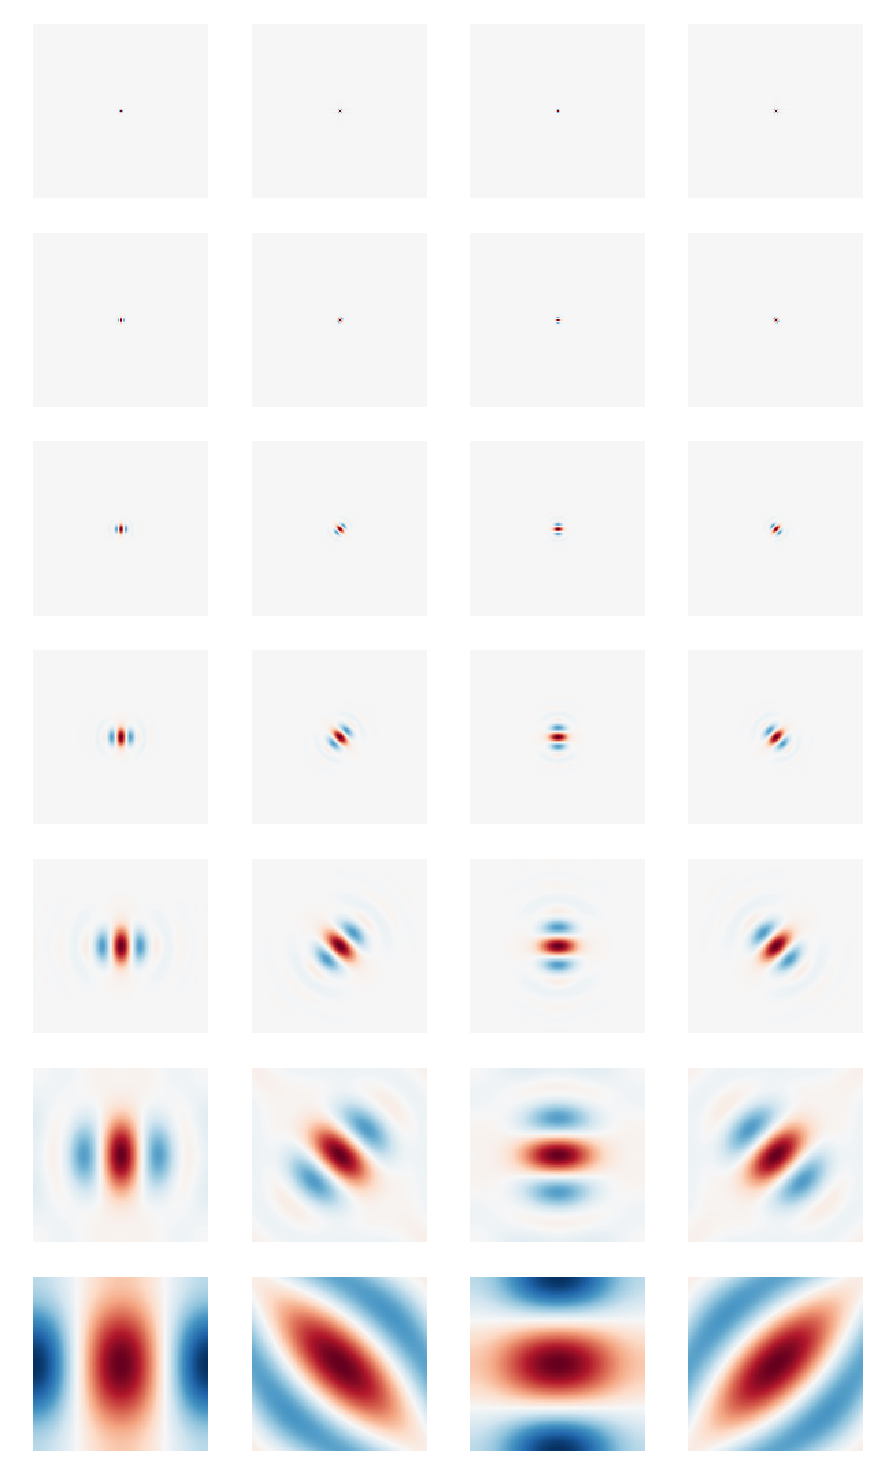

In [7]:
# What does it look like in real space?

plt.rcParams["figure.figsize"] = (15,15*J/L)
figure, ax = plt.subplots(ncols=L, nrows=J)
for j in range(J):
    for l in range(L):
        wavelet = np.fft.fftshift(np.real(np.fft.ifft2(ws[j*L+l])))
        amp = np.max(np.abs(wavelet))
        ax[j, l].matshow(wavelet, cmap='RdBu_r', vmin=-amp, vmax=amp)
        ax[j, l].axis("off")

## Define the wavelet scattering transform

In [8]:
# Send wavelets to device
ws = torch.from_numpy(ws).to(device)

In [9]:
# First we define a wavelet decomposition using the filters above. Note that the decompostision is not orthogonal.

def wavelet_dec(x):
    """x must be on device first."""
    x_hat = torch.fft.fft2(x)
    return torch.real(torch.fft.ifft2(x_hat[None, ...]*ws))

Test on one image:

In [10]:
output = wavelet_dec(torch.from_numpy(images[0]).to(device))

output.shape

torch.Size([28, 128, 128])

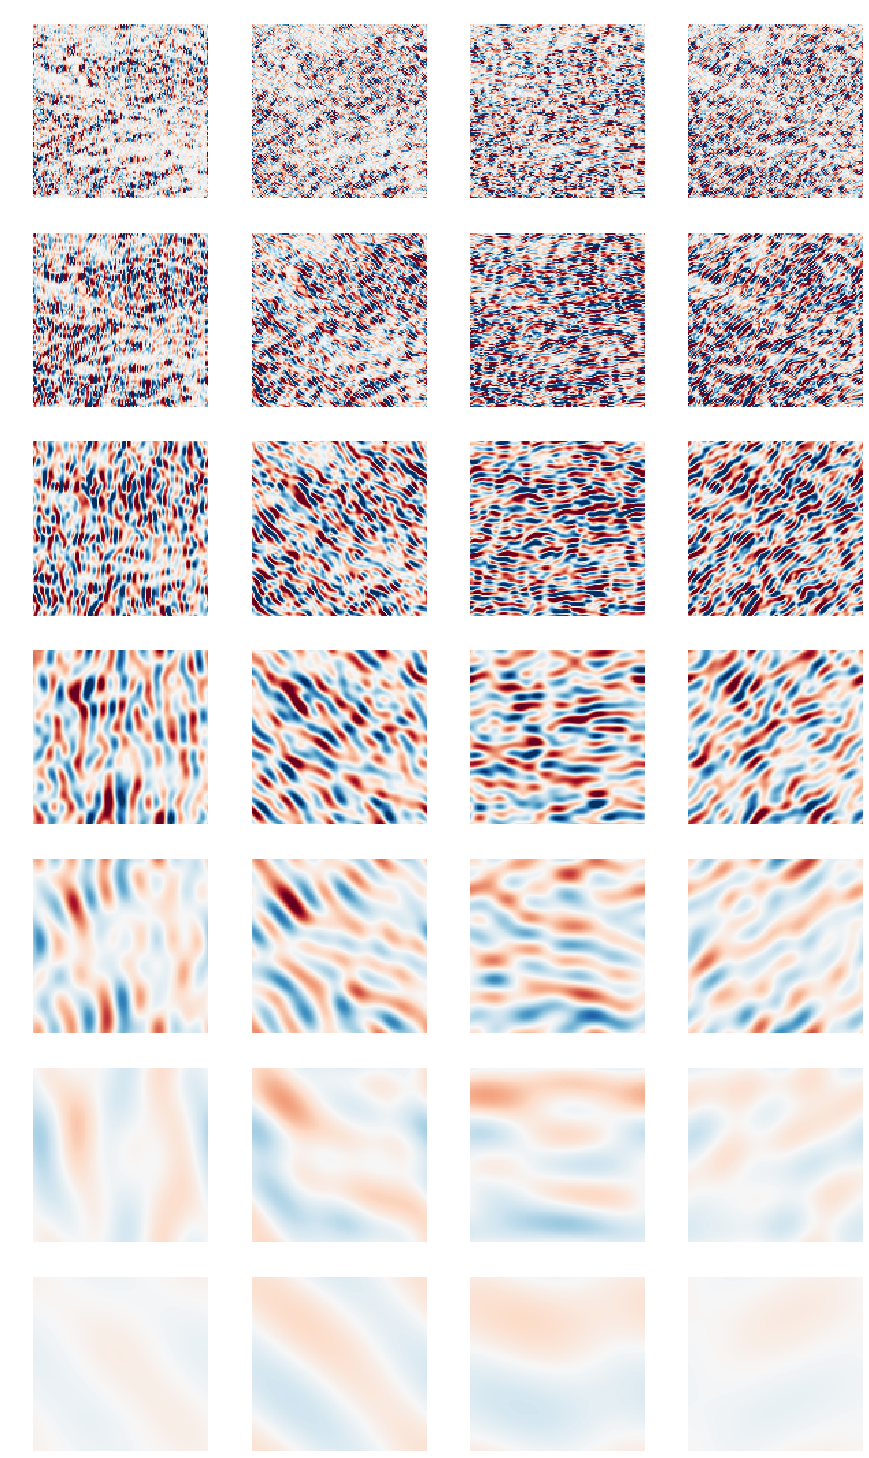

In [11]:
plt.rcParams["figure.figsize"] = (15,15*J/L)
figure, ax = plt.subplots(ncols=L, nrows=J)
for j in range(J):
    for l in range(L):
        ax[j, l].matshow(output[j*L+l].detach().cpu(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        ax[j, l].axis("off")

Then we define the WST based on the wavelet decomposition:

In [12]:
def wavelet_moments(x):
    """Computes wavelet scattering twice. Second pass is on absolute values"""
    fieldss = []
    scat = wavelet_dec(x)
    for wave in scat:
        fieldss.append(wavelet_dec(torch.abs(wave)))
    
    # First order
    moments = [torch.mean(x)]
    for wave in scat:
        moments.append(torch.mean(torch.abs(wave)))
    # Second order
    for fields in fieldss:
        for field in fields:
            moments.append(torch.mean(torch.abs(field)))
    return torch.stack(moments)

# First order only
def wavelet_moments_first(x):
    """Computes wavelet scattering twice. Second pass is on absolute values"""
    moments = [torch.mean(x)]
    scat = wavelet_dec(x)
    for wave in scat:
        moments.append(torch.mean(torch.abs(wave)))
    return torch.stack(moments)

In [13]:
mo = wavelet_moments(torch.from_numpy(image).to(device))

In [14]:
print(f'Number of scattering coefficients: {len(mo)}, Number of pixels: {image.size}')

Number of scattering coefficients: 813, Number of pixels: 16384


## Microcanonical generative model

As in the first notebook, we want to generate an image with matching WST moments with respect to one example, in other words, we want to generate $x_1$, such that:
$$
|S(x)-S(x_0)|<\varepsilon
$$

💡 Try with an image that is clearly not a texture, you will get a nice abstract drawing!

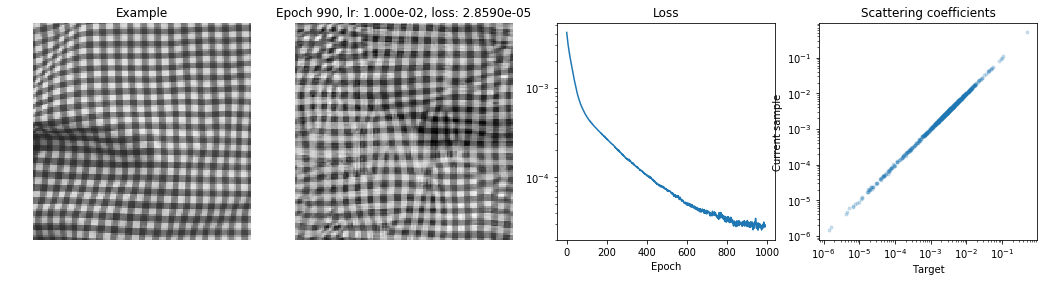

In [15]:
# Image number
i = 3

image = images[i]
S0 = wavelet_moments(torch.from_numpy(image).to(device))
S0_plot = S0.detach().cpu()
S0_mask = S0_plot > 1e-9


# Create trainable input image
# ----------------------------

# From random values
x = torch.rand(image.shape, requires_grad=True, device=device)

# From low noise
#x = torch.full(image.shape, 0.5, requires_grad=True, device=device)
#with torch.no_grad():
#    x += 0.1*torch.randn(image.shape, device=device)
    

# Optional randomized matching power spectrum density
pre_filter = False
if pre_filter:
    with torch.no_grad():
        # Noise
        x_hat = torch.fft.fft2(x)
        x_psd = torch.abs(x_hat)**2
        # Example
        psd0 = torch.abs(torch.fft.fft2(torch.from_numpy(image).to(device).contiguous()))**2
        # Filter
        x_hat2 = x_hat*torch.sqrt(psd0/x_psd)
        # Inverse
        x = torch.real(torch.fft.ifft2(x_hat2)).contiguous()
    x.requires_grad_()


# Optimizer
# ---------
optimizer = optim.Adam([x], lr=0.01)
#optimizer = optim.SGD([x], lr=1e4, momentum=0.9, dampening=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100)


# Optimization loop
# -----------------
max_iter = 1_000
losses = []

for epoch in range(max_iter):
    S1 = wavelet_moments(x)
    #loss = F.mse_loss(input=S1, target=S0)
    #loss = F.smooth_l1_loss(input=S(x), target=S0, beta=1.3e-3)
    loss = F.l1_loss(input=S1, target=S0)
    loss.backward(retain_graph=True)
    optimizer.step()
    
    optimizer.zero_grad()
    scheduler.step(loss.item())
    losses.append(loss.item())
    
    if epoch%10==0:
        # Plotting
        current_image = x.detach().cpu().numpy()
        clear_output(wait=True)
        
        
        plt.rcParams["figure.figsize"] = (18,4)
        figure, ax = plt.subplots(ncols=4)
        ax[0].imshow(image, cmap='gray', vmin=0, vmax=1)
        ax[0].set_title("Example")
        ax[0].axis('off')

        ax[1].imshow(current_image, cmap='gray', vmin=0, vmax=1)
        #ax[1].set_title(f"Epoch {epoch}, lr: {scheduler.get_last_lr()[0]:1.6f}, loss: {loss.item():1.3e}")
        ax[1].set_title(f"Epoch {epoch}, lr: {scheduler._last_lr[0]:1.3e}, loss: {loss.item():1.4e}")
        ax[1].axis('off')

        if len(losses) < 50:
            ls = 'o-'
        else:
            ls = '-'
        ax[2].semilogy(losses, ls)
        ax[2].set_xlabel('Epoch')
        ax[2].set_title('Loss')
        
        
        ax[3].loglog(S0_plot[S0_mask], S1.detach().cpu()[S0_mask], '.', alpha=0.2)
        ax[3].set_title('Scattering coefficients')
        ax[3].set_xlabel('Target')
        ax[3].set_ylabel('Current sample')
        plt.show()

## Save image

In [16]:
now = datetime.datetime.now()

x1 = x.detach().cpu().numpy()
x1[x1>1] = 1
x1[x1<0] = 0
io.imsave(f'outputs/{now.strftime("%Y-%m-%d %H:%M:%S")}_J{J}_L{L}_output.tiff', img_as_ubyte(x1))